In [1]:
import datetime
import json
import boto3
import io
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns

OA MacAir で権限の関係で実行できない。2019-01-30 原因不明

In [2]:
iam = boto3.client('iam')
sts = boto3.client('sts')

# Get the arn represented by the currently configured credentials
arn = sts.get_caller_identity()['Arn']
# Create an arn representing the objects in a bucket
bucket_objects_arn = 'arn:aws:s3:::%s/*' % '2019/01/28/10/btc-stream-delivery-1-2019-01-28-10-13-58-f7bb7bfb-d907-4841-b6c4-be47f3fb93f8'
# Run the policy simulation for the basic s3 operations
results = iam.simulate_principal_policy(
    PolicySourceArn=arn,
    ResourceArns=[bucket_objects_arn],
    ActionNames=['s3:PutObject', 's3:GetObject', 's3:DeleteObject']
)
for result in results['EvaluationResults']:
    print("%s - %s" % (result['EvalActionName'], result['EvalDecision']))

s3:PutObject - implicitDeny
s3:GetObject - implicitDeny
s3:DeleteObject - implicitDeny


In [3]:
bucket = "btc-realtime-data"
file_key = "2019/01/28/10/btc-stream-delivery-1-2019-01-28-10-13-58-f7bb7bfb-d907-4841-b6c4-be47f3fb93f8"
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=file_key)
df = pd.read_json(obj['Body'].read().decode('utf-8').replace('}{', '},{'), lines=True)

In [7]:
def parse_df(df):
    btc_df = pd.DataFrame(columns=['product_code', 'timestamp', 'tick_id', 
                               'best_bid', 'best_ask', 'best_bid_size', 
                               'best_ask_size', 'total_bid_depth', 'total_ask_depth',
                               'ltp', 'volume', 'volume_by_product'])
    for index, row in df.iterrows():
        #print(row['message']['volume'])
        btc_df = btc_df.append(row['message'], ignore_index=True)
    return btc_df

In [8]:
btc_df = parse_df(df)

In [11]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 12 columns):
product_code         743 non-null object
timestamp            743 non-null object
tick_id              743 non-null object
best_bid             743 non-null object
best_ask             743 non-null object
best_bid_size        743 non-null float64
best_ask_size        743 non-null float64
total_bid_depth      743 non-null float64
total_ask_depth      743 non-null float64
ltp                  743 non-null object
volume               743 non-null float64
volume_by_product    743 non-null float64
dtypes: float64(6), object(6)
memory usage: 69.7+ KB


from local file for testing

In [6]:
with open('/Users/sishida/Downloads/btc-stream-delivery-1-2019-01-28-10-13-58-f7bb7bfb-d907-4841-b6c4-be47f3fb93f8', 'r') as f:
    text = f.read()

text = '[' + text.replace('}{', '},{') + ']'
#print(type(text))
obj = json.loads(text)
df = pd.DataFrame(obj)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sishida/Downloads/btc-stream-delivery-1-2019-01-28-10-13-58-f7bb7bfb-d907-4841-b6c4-be47f3fb93f8'

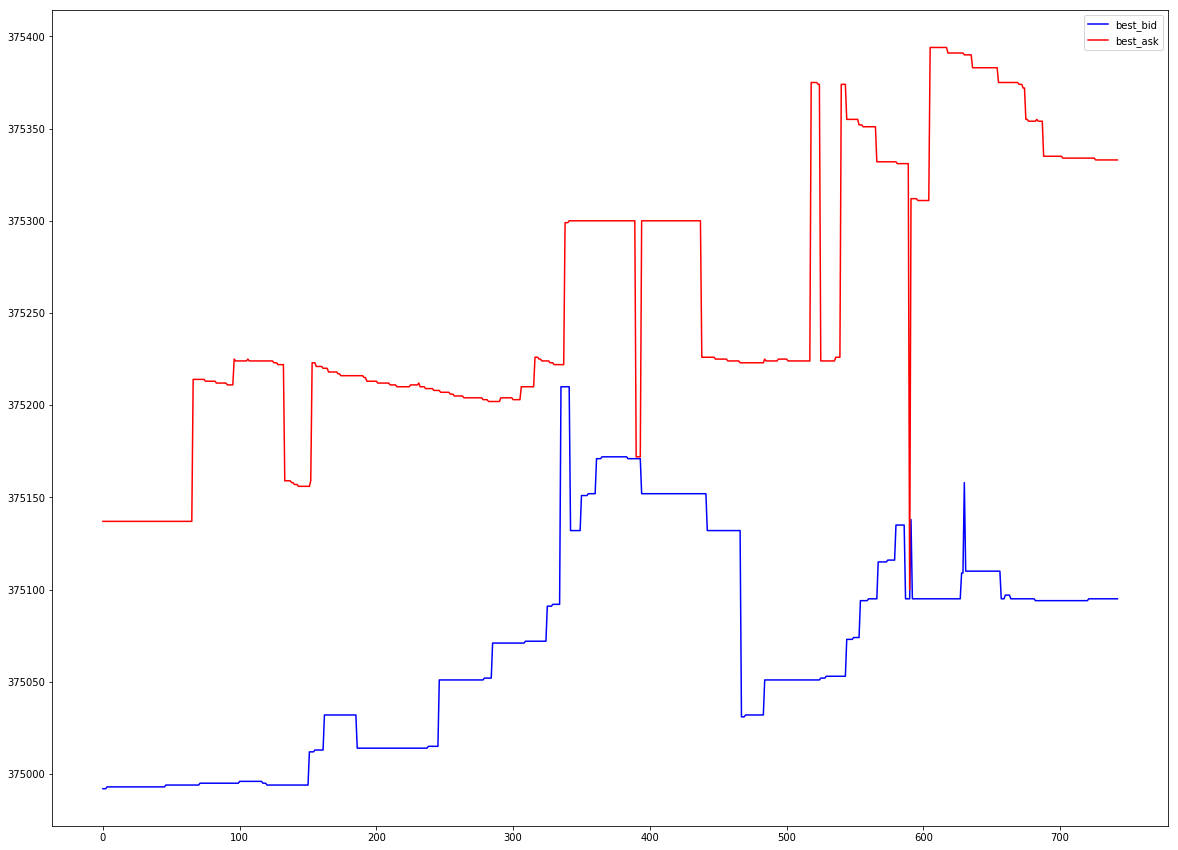

In [10]:
plt.figure(figsize=(20, 15))
plt.plot(btc_df.index, btc_df.best_bid, color='b')
plt.plot(btc_df.index, btc_df.best_ask, color='r')
plt.legend()

In [63]:
df3 = pd.DataFrame(df2)

In [64]:
df3.head()

,message
0,"{'product_code': 'BTC_JPY', 'timestamp': '2019..."
1,"{'product_code': 'BTC_JPY', 'timestamp': '2019..."
2,"{'product_code': 'BTC_JPY', 'timestamp': '2019..."
3,"{'product_code': 'BTC_JPY', 'timestamp': '2019..."
4,"{'product_code': 'BTC_JPY', 'timestamp': '2019..."


## with AWS Athena

In [2]:
athena = boto3.client('athena', region_name='ap-northeast-1')

In [3]:
DATABASE_NAME = 'btc_realtime_data'
S3BUCKET_NAME = 'aws-athena-query-results-546666693273-ap-northeast-1'

In [5]:
response = athena.start_query_execution(
    QueryString='SELECT * from btc_realtime_data.btc_ticks_2',
    QueryExecutionContext={
        'Database': DATABASE_NAME
    },
    ResultConfiguration={
        'OutputLocation': 's3://' + S3BUCKET_NAME
    }
)
print(response)

{'QueryExecutionId': 'b28a2717-5c85-40eb-8f01-fe8450c87fa2', 'ResponseMetadata': {'RequestId': '1800a717-78d7-4495-a56a-232c42a75a7d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Sat, 09 Feb 2019 11:17:28 GMT', 'x-amzn-requestid': '1800a717-78d7-4495-a56a-232c42a75a7d', 'content-length': '59', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [11]:
result = athena.get_query_results(
    QueryExecutionId='b28a2717-5c85-40eb-8f01-fe8450c87fa2',
    #NextToken='',
    MaxResults=100
)

## using PyAthenaJDBC

In [2]:
import contextlib
from pyathenajdbc import connect
from pyathenajdbc.util import as_pandas

In [4]:
session = boto3.Session(profile_name='soujiro0725')
credentials = session.get_credentials()
credentials = credentials.get_frozen_credentials()

In [ ]:
conn = connect(
            access_key=credentials.access_key,
            secret_key=credentials.secret_key,
            s3_staging_dir='s3://btc-realtime-data-query',
            region_name='ap-northeast-1'
)
df = pd.read_sql("""SELECT message.timestamp FROM "btc_realtime_data"."btc_ticks_2" limit 10""", conn)

In [4]:
with contextlib.closing(
    connect(s3_staging_dir='s3://btc-realtime-data-query/',
           region_name='ap-northeast-1')) as conn:
    with conn.cursor() as cursor:
        cursor.execute("""SELECT message.timestamp FROM "btc_realtime_data"."btc_ticks_2" limit 10""")
        df = as_pandas(cursor)

java.sql.SQLExceptionPyRaisable: java.sql.SQLException: [Simba][AthenaJDBC](100071) An error has been thrown from the AWS Athena client. User: arn:aws:iam::004092997205:user/sishida-cli is not authorized to perform: athena:StartQueryExecution on resource: arn:aws:athena:ap-northeast-1:004092997205:workgroup/primary [Execution ID not available]

## using PyAthena

In [2]:
from pyathena import connect

In [6]:
conn = connect(
    aws_access_key_id=credentials.access_key,
    aws_secret_access_key=credentials.secret_key,
    s3_staging_dir='s3://btc-realtime-data-query/',
    region_name='ap-northeast-1'
)

In [9]:
df = pd.read_sql("""SELECT message.timestamp,message.best_bid FROM 'btc_realtime_data'.'btc_ticks_2'""", conn)

Failed to execute query.
Traceback (most recent call last):
  File "/Users/sishida/.pyenv/versions/3.6.3/envs/btc3.6/lib/python3.6/site-packages/pyathena/common.py", line 166, in _execute
    **request)
  File "/Users/sishida/.pyenv/versions/3.6.3/envs/btc3.6/lib/python3.6/site-packages/pyathena/util.py", line 44, in retry_api_call
    return retry(func, *args, **kwargs)
  File "/Users/sishida/.pyenv/versions/3.6.3/envs/btc3.6/lib/python3.6/site-packages/tenacity/__init__.py", line 358, in call
    do = self.iter(retry_state=retry_state)
  File "/Users/sishida/.pyenv/versions/3.6.3/envs/btc3.6/lib/python3.6/site-packages/tenacity/__init__.py", line 319, in iter
    return fut.result()
  File "/Users/sishida/.pyenv/versions/3.6.3/lib/python3.6/concurrent/futures/_base.py", line 425, in result
    return self.__get_result()
  File "/Users/sishida/.pyenv/versions/3.6.3/lib/python3.6/concurrent/futures/_base.py", line 384, in __get_result
    raise self._exception
  File "/Users/sishida/.p

DatabaseError: Execution failed on sql: SELECT message.timestamp,message.best_bid FROM 'btc_realtime_data'.'btc_ticks_2'
An error occurred (InvalidRequestException) when calling the StartQueryExecution operation: line 1:48: mismatched input ''btc_realtime_data'' expecting {'(', 'ADD', 'ALL', 'SOME', 'ANY', 'AT', 'NO', 'SUBSTRING', 'POSITION', 'TINYINT', 'SMALLINT', 'INTEGER', 'DATE', 'TIME', 'TIMESTAMP', 'INTERVAL', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND', 'ZONE', 'FILTER', 'OVER', 'PARTITION', 'RANGE', 'ROWS', 'PRECEDING', 'FOLLOWING', 'CURRENT', 'ROW', 'SCHEMA', 'COMMENT', 'VIEW', 'REPLACE', 'GRANT', 'REVOKE', 'PRIVILEGES', 'PUBLIC', 'OPTION', 'EXPLAIN', 'ANALYZE', 'FORMAT', 'TYPE', 'TEXT', 'GRAPHVIZ', 'LOGICAL', 'DISTRIBUTED', 'VALIDATE', 'SHOW', 'TABLES', 'VIEWS', 'SCHEMAS', 'CATALOGS', 'COLUMNS', 'COLUMN', 'USE', 'PARTITIONS', 'FUNCTIONS', 'TO', 'SYSTEM', 'BERNOULLI', 'POISSONIZED', 'TABLESAMPLE', 'UNNEST', 'ARRAY', 'MAP', 'SET', 'RESET', 'SESSION', 'DATA', 'START', 'TRANSACTION', 'COMMIT', 'ROLLBACK', 'WORK', 'ISOLATION', 'LEVEL', 'SERIALIZABLE', 'REPEATABLE', 'COMMITTED', 'UNCOMMITTED', 'READ', 'WRITE', 'ONLY', 'CALL', 'INPUT', 'OUTPUT', 'CASCADE', 'RESTRICT', 'INCLUDING', 'EXCLUDING', 'PROPERTIES', 'FUNCTION', 'RETURNS', 'LANGUAGE', 'OPTIONS', 'SCALAR', 'AGGREGATE', 'WINDOW', 'NFD', 'NFC', 'NFKD', 'NFKC', 'IF', 'NULLIF', 'COALESCE', IDENTIFIER, DIGIT_IDENTIFIER, QUOTED_IDENTIFIER, BACKQUOTED_IDENTIFIER}
unable to rollback

In [16]:
df.head()

,channel,message
0,lightning_ticker_BTC_JPY,"{product_code=BTC_JPY, timestamp=2019-02-09T05..."
1,lightning_ticker_BTC_JPY,"{product_code=BTC_JPY, timestamp=2019-02-09T05..."
2,lightning_ticker_BTC_JPY,"{product_code=BTC_JPY, timestamp=2019-02-09T05..."
3,lightning_ticker_BTC_JPY,"{product_code=BTC_JPY, timestamp=2019-02-09T05..."
4,lightning_ticker_BTC_JPY,"{product_code=BTC_JPY, timestamp=2019-02-09T05..."


In [22]:
df2 = df['message'].to_frame()

In [24]:
df2.head()

,message
0,"{product_code=BTC_JPY, timestamp=2019-02-09T05..."
1,"{product_code=BTC_JPY, timestamp=2019-02-09T05..."
2,"{product_code=BTC_JPY, timestamp=2019-02-09T05..."
3,"{product_code=BTC_JPY, timestamp=2019-02-09T05..."
4,"{product_code=BTC_JPY, timestamp=2019-02-09T05..."
